In [1]:
# python 3.10.9
import numpy as np
from scipy.linalg.blas import ddot, dscal, daxpy, dger, drotg, drot
import time
import matplotlib.pyplot as plt

In [2]:
#view what BLAS and LAPACK libraries NumPy is using
#np.__config__.show()

#### Gram-Schmidt orthogonalization of the columns of A

<div style="max-width:250px;margin-left: 0; margin-right: auto;">

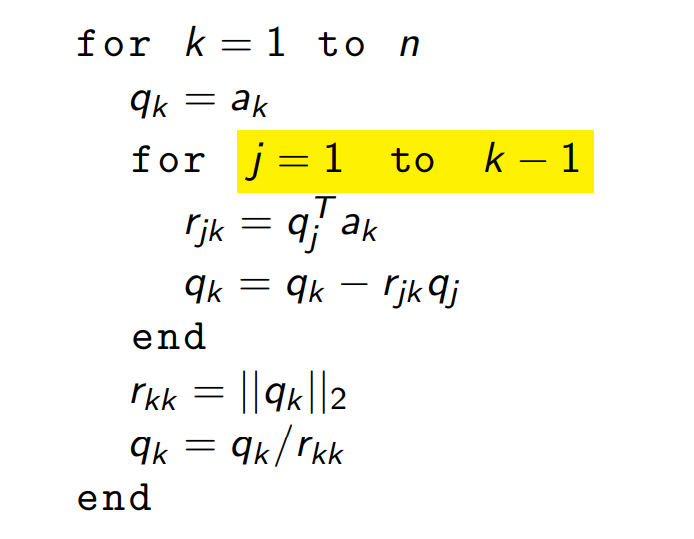

</div>

In [3]:
def gram_schmidt(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))
    
    for k in range(n):
        Q[:, k] = A[:, k]
        # Orthogonalize against all previously computed q_j's
        for j in range(k):
            # Compute r_jk = q_j^T * a_k which represents the projection of a_k onto q_j
            R[j, k] = ddot(Q[:, j], A[:, k])  # BLAS dot product
            # Subtract the projection of a_k onto q_j from q_k to make q_k orthogonal to q_j
            Q[:, k] -= R[j, k] * Q[:, j]

        # Compute r_kk as the norm of q_k
        R[k, k] = np.linalg.norm(Q[:, k])
        #Q[:, k] = dscal(1.0 / R[k, k], Q[:, k])  # BLAS scaling to normalize
        Q[:, k] /= R[k, k]
    
    return Q, R

#Returns:
# Q: m x n orthogonal matrix.
# R: n x n upper triangular matrix.


#### Modified Gram-Schmidt orthogonalization of the columns of A

<div style="max-width:250px;margin-left: 0; margin-right: auto;">

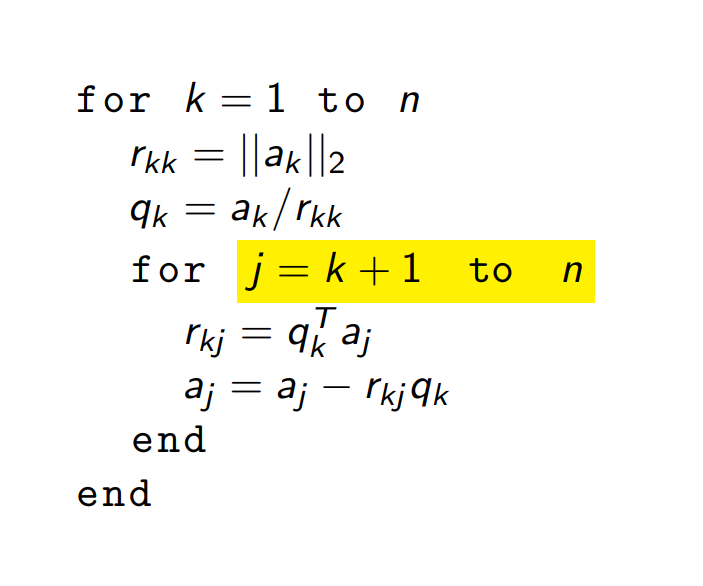

</div>

In [4]:
def modified_gram_schmidt(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))
    
    for k in range(n):
        # Compute rkk and qk (normalize the current column ak)
        R[k, k] = np.linalg.norm(A[:, k])
        #Q[:, k] = dscal(1.0 / R[k, k], A[:, k].copy())  # Normalize q_k = a_k / r_kk
        Q[:, k] = A[:, k] / R[k, k]

        # Orthogonalize subsequent vectors
        for j in range(k + 1, n):
            R[k, j] = ddot(Q[:, k], A[:, j])  # Compute r_kj = q_k^T a_j
            A[:, j] -= R[k, j] * Q[:, k]

    return Q, R

#Returns:
# Q (np.ndarray): The orthogonalized matrix with shape (m, n).
# R (np.ndarray): The upper triangular values of the projection coefficients with shape (n, n) such that A = Q * R.

#### Householder-based QR factorization of A

In [5]:
def householder_qr(A):
    m, n = A.shape
    R = A.copy()  
    Q = np.eye(m)  # Initialize Q as an identity matrix
    
    for k in range(n):
        # Extract the vector to reflect
        x = R[k:, k]
        norm_x = np.linalg.norm(x)
        
        # Construct the Householder vector
        v = x.copy()
        v[0] += np.copysign(norm_x, x[0])  # Adjust sign to avoid cancellation
        v /= np.linalg.norm(v)

        # Apply the transformation to R
        for j in range(k, n):

            ###### the commented lines have 0 orthogonolity error (perfect align) but huge runtime, cant be used after (400,100), exceeds 45s ######
            #dot_product = ddot(v, R[k:, j])    # Calculate dot product v^T * R[k:, j]
            #dger(-2 * dot_product, v, R[k:, j], overwrite_x=True)  # Update R[k:, j] = R[k:, j] - 2 * dot_product * v

            R[k:, j] -= 2 * v * np.dot(v, R[k:, j]) # Update R[k:, j] = R[k:, j] - 2 * (v^T * R[k:, j]) * v
        
        # Apply the transformation to Q
        for j in range(m):

            #dot_product = ddot(v, Q[j, k:])
            #dger(-2 * dot_product, v, Q[j, k:], overwrite_x=True)

            Q[j, k:] -= 2 * v * np.dot(v, Q[j, k:]) # Update Q[j, k:] = Q[j, k:] - 2 * (v^T * Q[j, k:]) * v
    
    return Q, R

#### Givens rotation-based QR factorization of A

In [6]:
def givens_qr(A):
    m, n = A.shape
    R = A.copy()
    Q = np.eye(m)

    for j in range(n):
        for i in range(m-1, j, -1):  # Apply Givens to zero below-diagonal entries in j-th column
            #if R[i, j] != 0:
                # Calculate Givens rotation parameters to zero R[i, j]
                a, b = R[i-1, j], R[i, j]
                #c, s = drotg(a, b)  # drotg returns the cosine and sine for the rotation
                r = np.hypot(a, b)  # Compute the hypotenuse
                c = a / r  # Cosine
                s = -b / r  # Sine
                #c and s define the Givens rotation matrix to zero out b.

                # Apply Givens rotation to the rows in R (affects columns j to n)
                #for k in range(j, n):
                    #R[i-1, k], R[i, k] = drot(R[i-1, k], R[i, k], c, s)
                R[i-1:i+1, j:n] = np.array([[c, s], [-s, c]]).dot(R[i-1:i+1, j:n])  # Update R with the Givens rotation

                # Accumulate the rotation into Q
                #for k in range(m):
                    #Q[i-1, k], Q[i, k] = drot(Q[i-1, k], Q[i, k], c, s)
                Q[:, [i-1, i]] = Q[:, [i-1, i]].dot(np.array([[c, -s], [s, c]]))

    return Q.T, R  # Q needs to be transposed to match the usual QR form

#### Testing


Testing Set A with shape (100, 100):
Classical Gram-Schmidt | Runtime: 0.0218s | Orthogonality Error: 7.5872e-12 | Efficiency: 0.05%
Modified Gram-Schmidt | Runtime: 0.0219s | Orthogonality Error: 2.2854e-13 | Efficiency: 0.05%
Householder | Runtime: 0.1024s | Orthogonality Error: 9.8027e-15 | Efficiency: 0.01%
Givens | Runtime: 0.0922s | Orthogonality Error: 1.3425e-14 | Efficiency: 0.01%

Testing Set A with shape (200, 100):
Classical Gram-Schmidt | Runtime: 0.0210s | Orthogonality Error: 3.8573e-14 | Efficiency: 0.09%
Modified Gram-Schmidt | Runtime: 0.0313s | Orthogonality Error: 1.2446e-14 | Efficiency: 0.06%
Householder | Runtime: 0.1481s | Orthogonality Error: 1.3130e-14 | Efficiency: 0.02%
Givens | Runtime: 0.2651s | Orthogonality Error: 1.8774e-14 | Efficiency: 0.01%

Testing Set A with shape (300, 100):
Classical Gram-Schmidt | Runtime: 0.0341s | Orthogonality Error: 2.1769e-14 | Efficiency: 0.09%
Modified Gram-Schmidt | Runtime: 0.0309s | Orthogonality Error: 1.2024e-14 | E

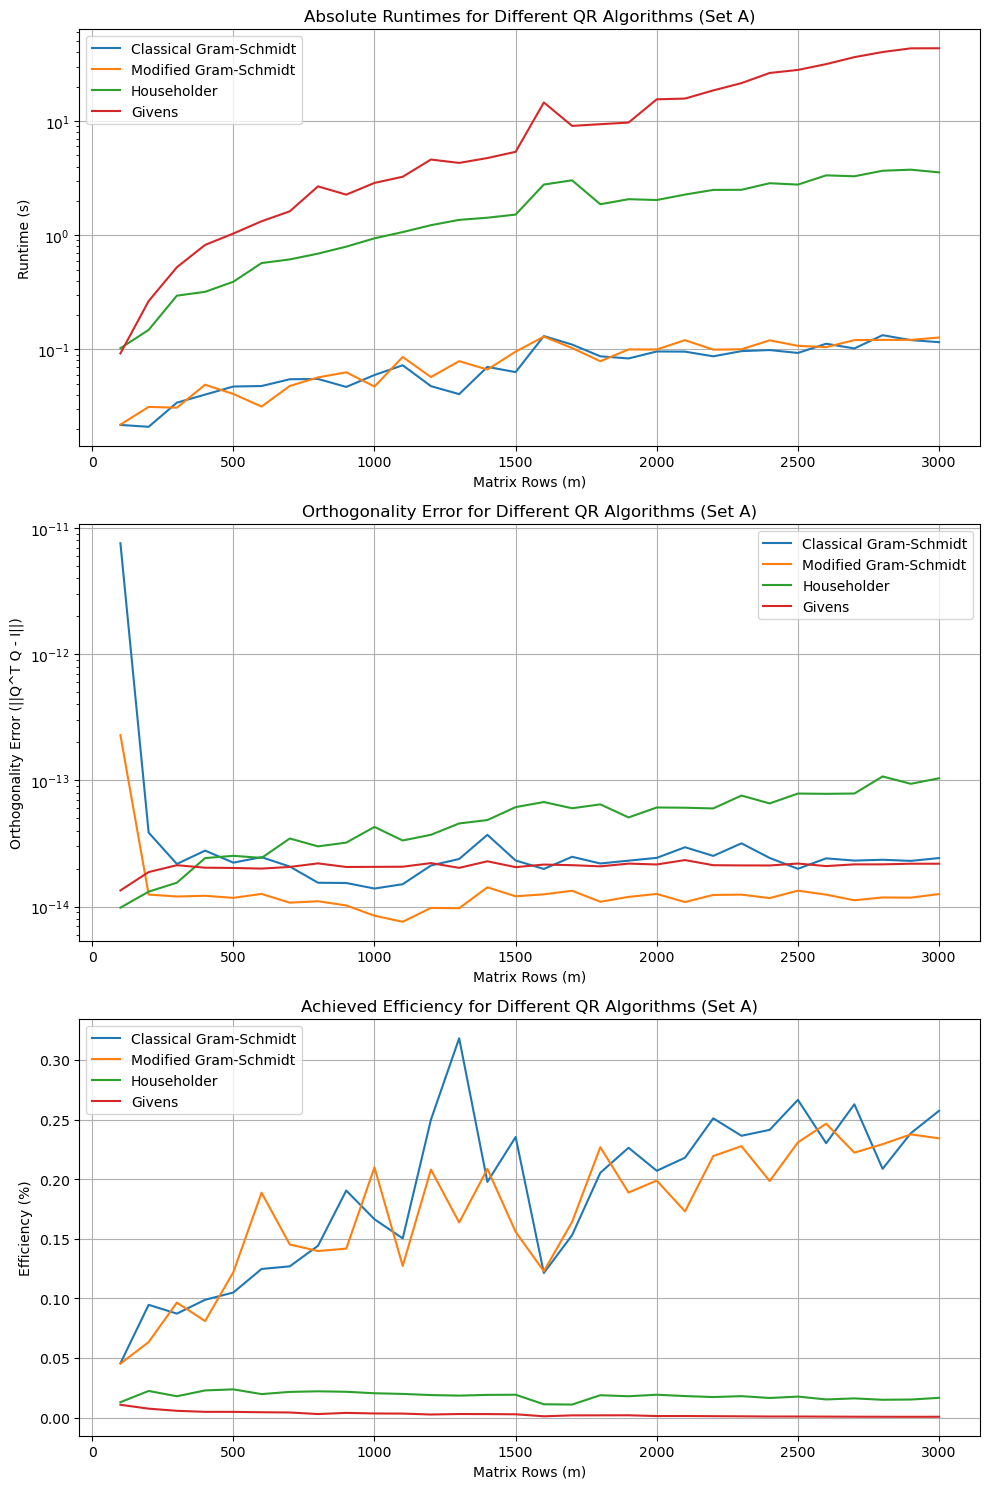

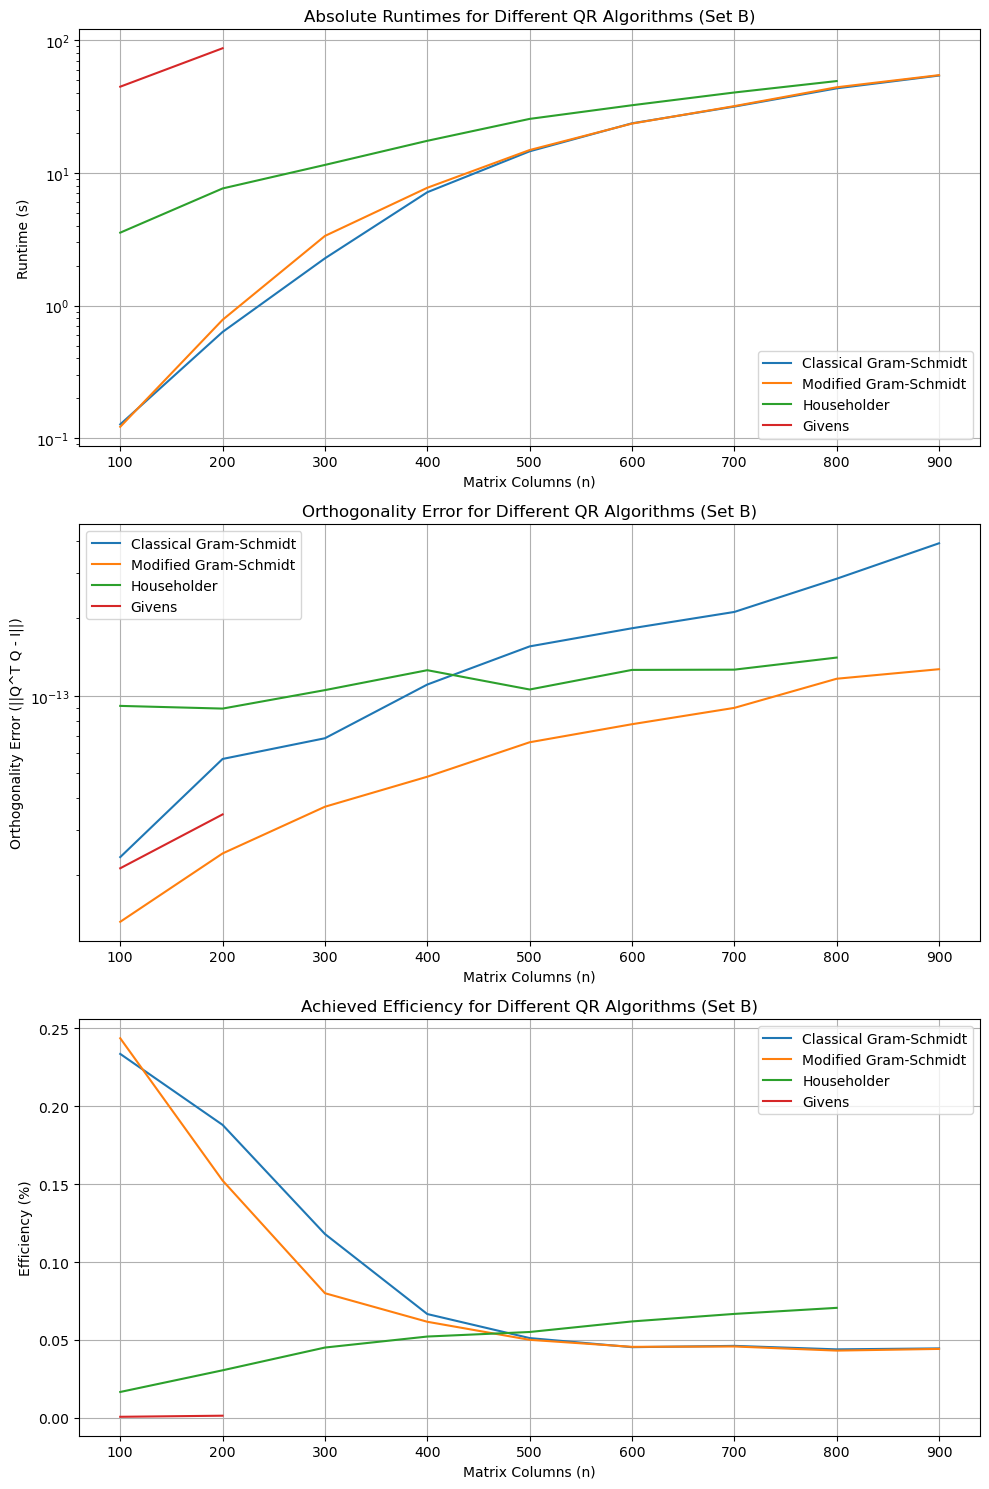

In [7]:
P_theoretical = 100.8e9  # in FLOPS (100.8 GFLOPS using base clock)

# Flops calculations for each algorithm
def calculate_flops(method, m, n):
    if method == "Classical Gram-Schmidt" or method == "Modified Gram-Schmidt":
        return m * n**2  # O(mn^2)
    elif method == "Householder":
        return 2 * m * n**2 - (2 / 3) * n**3  # O(2mn^2 - (2/3)n^3)
    elif method == "Givens":
        return m * n**2  # O(mn^2)
    return 0

efficiency_results_A = {'Classical Gram-Schmidt': [], 'Modified Gram-Schmidt': [],
                         'Householder': [], 'Givens': []}

efficiency_results_B = {'Classical Gram-Schmidt': [], 'Modified Gram-Schmidt': [],
                         'Householder': [], 'Givens': []}


# List of dimensions for Sets A and B
m_values_A = list(range(100, 3100, 100))
n_values_B = list(range(100, 3100, 100))

# Accuracy and runtime function for each method
def evaluate_algorithm(algorithm, A, name):
    start_time = time.time()
    Q, R = algorithm(A)
    runtime = time.time() - start_time
    # Orthogonality measure ||Q.T @ Q - I||_1
    orthogonality_error = np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1]), ord=1)
    return runtime, orthogonality_error


# Initialize results storage and time limit flags for each method
results = {'Classical Gram-Schmidt': [], 'Modified Gram-Schmidt': [], 
           'Householder': [], 'Givens': []}
time_limit_exceeded = {'Classical Gram-Schmidt': False, 
                       'Modified Gram-Schmidt': False, 
                       'Householder': False, 
                       'Givens': False}

# Test each method on Set A
for m in m_values_A:
    A = np.random.rand(m, 100) 
    print(f"\nTesting Set A with shape ({m}, 100):")
    
    for name, algorithm in [("Classical Gram-Schmidt", gram_schmidt), 
                            ("Modified Gram-Schmidt", modified_gram_schmidt), 
                            ("Householder", householder_qr), 
                            ("Givens", givens_qr)]:
        if time_limit_exceeded[name]:
            continue
        
        try:
            start_time = time.time()
            Q, R = algorithm(A)
            runtime = time.time() - start_time
            
            # Calculate flops
            flops = calculate_flops(name, m, 100)
            P_sustained = flops / runtime  # in FLOPS
            efficiency = (P_sustained / P_theoretical) * 100  # as percentage
            
            # Orthogonality measure
            orthogonality_error = np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1]), ord=1)

            efficiency_results_A[name].append((m, 100, runtime, orthogonality_error, efficiency))
            
            if runtime <= 45:
                print(f"{name} | Runtime: {runtime:.4f}s | Orthogonality Error: {orthogonality_error:.4e} | Efficiency: {efficiency:.2f}%")
            else:
                print(f"{name} exceeded time limit on ({m}, 100)")
                time_limit_exceeded[name] = True  # Mark this method as exceeded

        except Exception as e:
            print(f"{name} failed on ({m}, 100) with error: {e}")
            time_limit_exceeded[name] = True  # Mark this method as failed
            break


# Reset time limit flags for testing Set B
time_limit_exceeded = {'Classical Gram-Schmidt': False, 
                       'Modified Gram-Schmidt': False, 
                       'Householder': False, 
                       'Givens': False}


# Test each method on Set B
for n in n_values_B:
    A = np.random.rand(3000, n)  
    print(f"\nTesting Set B with shape (3000, {n}):")
    
    for name, algorithm in [("Classical Gram-Schmidt", gram_schmidt), 
                            ("Modified Gram-Schmidt", modified_gram_schmidt), 
                            ("Householder", householder_qr), 
                            ("Givens", givens_qr)]:
        if time_limit_exceeded[name]:
            continue
        
        try:
            start_time = time.time()
            Q, R = algorithm(A)
            runtime = time.time() - start_time
            
            # Calculate flops
            flops = calculate_flops(name, 3000, n)
            P_sustained = flops / runtime  # in FLOPS
            efficiency = (P_sustained / P_theoretical) * 100  # as percentage
            
            # Orthogonality measure
            orthogonality_error = np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1]), ord=1)

            efficiency_results_B[name].append((3000, n, runtime, orthogonality_error, efficiency))
            
            if runtime <= 45:
                print(f"{name} | Runtime: {runtime:.4f}s | Orthogonality Error: {orthogonality_error:.4e} | Efficiency: {efficiency:.2f}%")
            else:
                print(f"{name} exceeded time limit on (3000, {n})")
                time_limit_exceeded[name] = True  # Mark this method as exceeded

        except Exception as e:
            print(f"{name} failed on (3000, {n}) with error: {e}")
            time_limit_exceeded[name] = True  # Mark this method as failed
            break

    
# Plotting for Set A
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for Set A
for name in efficiency_results_A:
    data = np.array(efficiency_results_A[name])
    m_values = data[:, 0]
    runtime_values = data[:, 2]
    error_values = data[:, 3]
    efficiency_values = data[:, 4]

    # Plot Absolute Runtime
    axs[0].plot(m_values, runtime_values, label=name)
    axs[0].set_title('Absolute Runtimes for Different QR Algorithms (Set A)')
    axs[0].set_xlabel('Matrix Rows (m)')
    axs[0].set_ylabel('Runtime (s)')
    axs[0].set_yscale('log')
    axs[0].grid(True)
    axs[0].legend()

    # Plot Orthogonality Error
    axs[1].plot(m_values, error_values, label=name)
    axs[1].set_title('Orthogonality Error for Different QR Algorithms (Set A)')
    axs[1].set_xlabel('Matrix Rows (m)')
    axs[1].set_ylabel('Orthogonality Error (||Q^T Q - I||)')
    axs[1].set_yscale('log')
    axs[1].grid(True)
    axs[1].legend()

    # Plot Achieved Efficiency
    axs[2].plot(m_values, efficiency_values, label=name)
    axs[2].set_title('Achieved Efficiency for Different QR Algorithms (Set A)')
    axs[2].set_xlabel('Matrix Rows (m)')
    axs[2].set_ylabel('Efficiency (%)')
    axs[2].set_yscale('linear')
    axs[2].grid(True)
    axs[2].legend()

plt.tight_layout()
plt.show()

# Plotting for Set B
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for Set B
for name in efficiency_results_B:
    data = np.array(efficiency_results_B[name])
    n_values = data[:, 1]
    runtime_values = data[:, 2]
    error_values = data[:, 3]
    efficiency_values = data[:, 4]

    # Plot Absolute Runtime
    axs[0].plot(n_values, runtime_values, label=name)
    axs[0].set_title('Absolute Runtimes for Different QR Algorithms (Set B)')
    axs[0].set_xlabel('Matrix Columns (n)')
    axs[0].set_ylabel('Runtime (s)')
    axs[0].set_yscale('log')
    axs[0].grid(True)
    axs[0].legend()

    # Plot Orthogonality Error
    axs[1].plot(n_values, error_values, label=name)
    axs[1].set_title('Orthogonality Error for Different QR Algorithms (Set B)')
    axs[1].set_xlabel('Matrix Columns (n)')
    axs[1].set_ylabel('Orthogonality Error (||Q^T Q - I||)')
    axs[1].set_yscale('log')
    axs[1].grid(True)
    axs[1].legend()

    # Plot Achieved Efficiency
    axs[2].plot(n_values, efficiency_values, label=name)
    axs[2].set_title('Achieved Efficiency for Different QR Algorithms (Set B)')
    axs[2].set_xlabel('Matrix Columns (n)')
    axs[2].set_ylabel('Efficiency (%)')
    axs[2].set_yscale('linear')
    axs[2].grid(True)
    axs[2].legend()

plt.tight_layout() 
plt.show()